# 🏠 Housing Price Prediction — Machine Learning

**Author:** Daeren Kim
**Project:** Housing Price Prediction Dashboard
**Notebook:** Machine Learning (Model Training & Evaluation)
**Date:** 29/11/2025

---

## Overview

This notebook focuses on predicting HDB resale flat prices using the processed dataset from the ETL pipeline.

Key tasks include:

* Loading and exploring the processed dataset
* Feature selection and preprocessing
* Training multiple machine learning models
* Evaluating and comparing model performance
* Hyperparameter tuning and final model selection
* Saving the best-performing model for deployment in the dashboard


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import warnings
from sklearn.exceptions import ConvergenceWarning

## 1) Loading Dataset

In [3]:
data_path = "../data/cleaned_resale_flat_price.csv"
df = pd.read_csv(data_path)
df.head()

,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,remaining_lease_years,resale_price,storey_range,street_name,town,year
0,406,Improved,2 Room,44.0,1979,Jan,61 years 04 months,61.333333,232000.0,10 To 12,Ang Mo Kio Ave 10,Ang Mo Kio,2017
1,108,New Generation,3 Room,67.0,1978,Jan,60 years 07 months,60.583333,250000.0,01 To 03,Ang Mo Kio Ave 4,Ang Mo Kio,2017
2,602,New Generation,3 Room,67.0,1980,Jan,62 years 05 months,62.416667,262000.0,01 To 03,Ang Mo Kio Ave 5,Ang Mo Kio,2017
3,465,New Generation,3 Room,68.0,1980,Jan,62 years 01 month,62.083333,265000.0,04 To 06,Ang Mo Kio Ave 10,Ang Mo Kio,2017
4,601,New Generation,3 Room,67.0,1980,Jan,62 years 05 months,62.416667,265000.0,01 To 03,Ang Mo Kio Ave 5,Ang Mo Kio,2017


## 2) Feature Selection & Preprocessing

In [5]:
# Investigate the number of unique values in each column
for col in df.columns:
    print(col, ": ", df[col].nunique())

block :  2743
flat_model :  21
flat_type :  7
floor_area_sqm :  187
lease_commence_date :  57
month :  12
remaining_lease :  693
remaining_lease_years :  690
resale_price :  4507
storey_range :  17
street_name :  576
town :  26
year :  9


Based on this, we will do one-hot encoding on flat type, storey range and town

In [6]:
# Features & Target
numeric_features = ['floor_area_sqm', 'remaining_lease_years', 'lease_commence_date', 'year']
categorical_low = ['flat_type', 'town', 'storey_range', 'month']
categorical_high = ['street_name']

X = df[numeric_features + categorical_low + categorical_high]
y = df['resale_price']

## 3) Model Forming

### Helper Function

In [30]:
def train_evaluate_model(
    X, y, model, param_grid=None, numeric_features=None,
    categorical_low=None, categorical_high=None, test_size=0.2,
    random_state=42, sample_size=None
):
    """
    Trains and evaluates a regression model with optional hyperparameter tuning.
    
    Parameters:
    - X, y: Features and target
    - model: any scikit-learn compatible regressor
    - param_grid: dict, optional, for RandomizedSearchCV
    - numeric_features: list of numeric column names
    - categorical_low: list of low-cardinality categorical column names
    - categorical_high: list of high-cardinality categorical column names (for TargetEncoder)
    - test_size: test split proportion
    - random_state: for reproducibility
    - sample_size: int, optional, number of rows to subsample for tuning
    
    Returns:
    - best_model: fitted pipeline
    - metrics: dict with MAE, RMSE, R²
    """
    # Subsample if specified
    if sample_size and sample_size < len(X):
        X, _, y, _ = train_test_split(
            X, y, train_size=sample_size, random_state=random_state
        )
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Preprocessor
    transformers = []
    if numeric_features:
        transformers.append(('num', StandardScaler(), numeric_features))
    if categorical_low:
        transformers.append(('cat_low', OneHotEncoder(handle_unknown='ignore'), categorical_low))
    if categorical_high:
        from category_encoders import TargetEncoder
        transformers.append(('cat_high', TargetEncoder(), categorical_high))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    # Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit with optional hyperparameter tuning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        if param_grid:
            search = RandomizedSearchCV(
                pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1
            )
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
        else:
            pipeline.fit(X_train, y_train)
            best_model = pipeline

    # Ensure X_test has proper feature names for LGBM / pipeline
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=X_train.columns)

    # Suppress UserWarnings during prediction
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        y_pred = best_model.predict(X_test)

    # Predictions and metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    
    return best_model, metrics


### Random Forest

In [31]:
rf_model = RandomForestRegressor(
            n_estimators=100, 
            max_depth=15,    
            min_samples_leaf=2, 
            n_jobs=-1,
            random_state=42
        )
rf_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}
rf_best, rf_metrics = train_evaluate_model(X, y, rf_model, param_grid=rf_grid,
                                           numeric_features=numeric_features,
                                           categorical_low=categorical_low,
                                           categorical_high=categorical_high, sample_size=75000)
print("Random Forest:", rf_metrics)
print(rf_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest: {'MAE': 25891.124217451237, 'RMSE': np.float64(38157.13399305303), 'R2': 0.9570999893593592}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'town',
                                                   'storey_range', 'month']),
                                                 ('cat_high', TargetEncoder(),
                                                  ['street_name

### XGBoost

In [32]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,
                             max_depth=6, random_state=42, objective='reg:squarederror',
                             n_jobs=-1)
xgb_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 6, 10],
    'model__learning_rate': [0.05, 0.1]
}
xgb_best, xgb_metrics = train_evaluate_model(X, y, xgb_model, param_grid=xgb_grid,
                                             numeric_features=numeric_features,
                                             categorical_low=categorical_low,
                                             categorical_high=categorical_high, sample_size=75000)
print("XGBoost:", xgb_metrics)
print(xgb_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost: {'MAE': 22265.3695215, 'RMSE': np.float64(31840.75323067839), 'R2': 0.9701274310962545}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'town',
                                                   'storey_range', 'month']),
                                                 ('cat_high', TargetEncoder(),
                                                  ['street_name'])])),
   

### Catboost

In [38]:
cat_model = cb.CatBoostRegressor(iterations=100, learning_rate=0.1,
                                depth=6, random_state=42, verbose=0)
cat_grid = {
    'model__iterations': [500, 1000],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.05, 0.1]
}
cat_best, cat_metrics = train_evaluate_model(X, y, cat_model, param_grid=cat_grid,
                                             numeric_features=numeric_features,
                                             categorical_low=categorical_low,
                                             categorical_high=categorical_high, sample_size=75000)
print("CatBoost:", cat_metrics)
print(cat_best.named_steps['model'].get_params())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CatBoost: {'MAE': 21445.68658855662, 'RMSE': np.float64(29737.4869857542), 'R2': 0.9739435986181663}
{'iterations': 1000, 'learning_rate': 0.1, 'depth': 8, 'loss_function': 'RMSE', 'verbose': 0, 'random_state': 42}


### Lightgbm

In [34]:
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1,
                              max_depth=-1, random_state=42, n_jobs=-1)
lgb_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [-1, 10, 20],
    'model__learning_rate': [0.05, 0.1]
}
lgb_best, lgb_metrics = train_evaluate_model(X, y, lgb_model, param_grid=lgb_grid,
                                             numeric_features=numeric_features,
                                             categorical_low=categorical_low,
                                             categorical_high=categorical_high, sample_size=75000)
print("LightGBM:", lgb_metrics)
print(lgb_best)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 521203.282611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `fo

/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] 

/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 521203.282611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the tr

/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 521203.282611


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 521203.282611


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 521203.282611
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 523388.299794
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 826
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 62
[LightGBM] [Info] Start training from score 522417.180323


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 65
[LightGBM] [Info] Start training from score 522336.254243
LightGBM: {'MAE': 25527.988238720798, 'RMSE': np.float64(35024.49214923254), 'R2': 0.9638548859656093}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                      

### Linear Regression

In [35]:
lin_model = LinearRegression()
lin_best, lin_metrics = train_evaluate_model(X, y, lin_model,
                                             numeric_features=numeric_features,
                                             categorical_low=categorical_low,
                                             categorical_high=categorical_high, sample_size=75000)
print("Linear Regression:", lin_metrics)
print(lin_best)

Linear Regression: {'MAE': 66973.32574480635, 'RMSE': np.float64(90573.65158961526), 'R2': 0.7582816282557691}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'town',
                                                   'storey_range', 'month']),
                                                 ('cat_high', TargetEncoder(),
                                                  ['street_name'])])),
                ('model', LinearRegression())])


### Lasso Regression

In [36]:
lasso_model = Lasso(random_state=42)
lasso_grid = {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
lasso_best, lasso_metrics = train_evaluate_model(X, y, lasso_model, param_grid=lasso_grid,
                                                 numeric_features=numeric_features,
                                                 categorical_low=categorical_low,
                                                 categorical_high=categorical_high, sample_size=75000)
print("Lasso Regression:", lasso_metrics)
print(lasso_best)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Lasso Regression: {'MAE': 50578.799481924194, 'RMSE': np.float64(66830.438308931), 'R2': 0.8684004135261901}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'town',
                                                   'storey_range', 'month']),
                                                 ('cat_high', TargetEncoder(),
                                                  ['street_name'])])),
                ('model', Lasso(alpha=0.01, random_s

### Ridge Regression

In [37]:
ridge_model = Ridge(random_state=42)
ridge_grid = {'model__alpha': [0.01, 0.1, 1.0, 10.0]}
ridge_best, ridge_metrics = train_evaluate_model(X, y, ridge_model, param_grid=ridge_grid,
                                                 numeric_features=numeric_features,
                                                 categorical_low=categorical_low,
                                                 categorical_high=categorical_high, sample_size=75000)
print("Ridge Regression:", ridge_metrics)
print(ridge_best)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/daerenkim/Documents/GitHub/HDB-Housing-Price-Prediction/HDB_venv/lib/python3.13/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Ridge Regression: {'MAE': 112949.48744734388, 'RMSE': np.float64(146055.0912595074), 'R2': 0.3714507586895597}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'remaining_lease_years',
                                                   'lease_commence_date',
                                                   'year']),
                                                 ('cat_low',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'town',
                                                   'storey_range', 'month']),
                                                 ('cat_high', TargetEncoder(),
                                                  ['street_name'])])),
                ('model', Ridge(alpha=10.0, random

## 4) Model and Results Comparison

In [47]:
metrics = {
    'Random Forest': {'MAE': 25891.124217451237, 'RMSE': np.float64(38157.13399305303), 'R2': 0.9570999893593592},
    'XGBoost': {'MAE': 22265.3695215, 'RMSE': np.float64(31840.75323067839), 'R2': 0.9701274310962545},
    'CatBoost': {'MAE': 21445.68658855662, 'RMSE': np.float64(29737.4869857542), 'R2': 0.9739435986181663},
    'LightGBM': {'MAE': 25527.988238720798, 'RMSE': np.float64(35024.49214923254), 'R2': 0.9638548859656093},
    'Linear Regression': {'MAE': 66973.32574480635, 'RMSE': np.float64(90573.65158961526), 'R2': 0.7582816282557691},
    'Lasso Regression': {'MAE': 50578.799481924194, 'RMSE': np.float64(66830.438308931), 'R2': 0.8684004135261901},
    'Ridge Regression': {'MAE': 112949.48744734388, 'RMSE': np.float64(146055.0912595074), 'R2': 0.3714507586895597}
}

df_metrics = pd.DataFrame(metrics).T
df_metrics.index.name = 'Models'
df_metrics = df_metrics.reset_index()
df_metrics

,Models,MAE,RMSE,R2
0,Random Forest,25891.124217,38157.133993,0.957100
1,XGBoost,22265.369522,31840.753231,0.970127
2,CatBoost,21445.686589,29737.486986,0.973944
3,LightGBM,25527.988239,35024.492149,0.963855
4,Linear Regression,66973.325745,90573.651590,0.758282
5,Lasso Regression,50578.799482,66830.438309,0.868400
6,Ridge Regression,112949.487447,146055.091260,0.371451


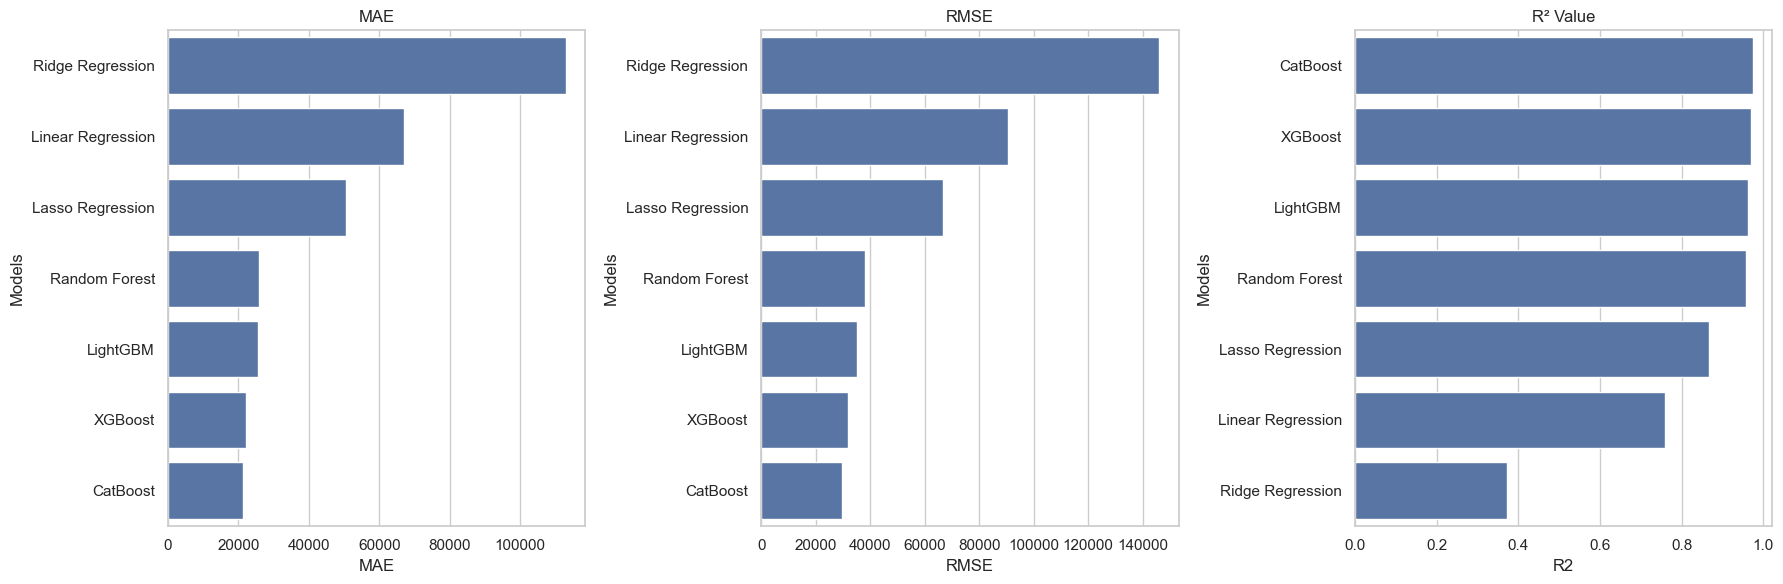

In [49]:
def plot_result():
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # MAE plot
    sns.barplot(x='MAE', y='Models', data=df_metrics.sort_values('MAE', ascending=False), ax=axes[0])
    axes[0].set_title('MAE')

    # RMSE plot
    sns.barplot(x='RMSE', y='Models', data=df_metrics.sort_values('RMSE', ascending=False), ax=axes[1])
    axes[1].set_title('RMSE')

    # R² plot
    sns.barplot(x='R2', y='Models', data=df_metrics.sort_values('R2', ascending=False), ax=axes[2])
    axes[2].set_title('R² Value')

    plt.tight_layout()
    plt.show()

plot_result()

It is quite clear that catboost wins in all category, with the lowest MAE, RMSE and the highest R^2

## 5) Finetune Catboost Model

In [63]:
def catboost():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define numerical features
    numeric_features = ['floor_area_sqm', 'remaining_lease_years', 'lease_commence_date', 'year']
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    # Define categorical features
    cat_features = ['flat_type', 'town', 'storey_range', 'month', 'street_name']  

    # Create CatBoost model
    cat_model = cb.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        loss_function='RMSE',
        verbose=0,
        random_state=42
    )

    # Train the model
    cat_model.fit(X_train, y_train, cat_features=cat_features)

    # Evaluate
    y_pred = cat_model.predict(X_test)

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import numpy as np

    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    print("CatBoost Metrics:", metrics)

    # Feature importance
    importances = cat_model.get_feature_importance()
    feature_names = X_train.columns
    feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

    print("\nTop 10 most important features:")
    for feature, importance in feature_importances[:10]:
        print(f"{feature}: {importance:.2f}")

catboost()

CatBoost Metrics: {'MAE': 20455.29104812613, 'RMSE': np.float64(28099.116548282764), 'R2': 0.9772401440770885}

Top 10 most important features:
year: 21.99
floor_area_sqm: 18.79
flat_type: 14.10
town: 13.31
lease_commence_date: 12.23
street_name: 11.22
storey_range: 4.32
remaining_lease_years: 3.67
month: 0.36


## 6) Save Final Model

Here are the final features chosen, after taking into account variables that are multicollinear and insignificant variables

In [7]:
def catboost_final():
    selected_features = ['year', 'floor_area_sqm', 'lease_commence_date', 'flat_type', 'town', 'storey_range']
    X_sel = X[selected_features]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.2, random_state=42
    )

    # Define numeric and categorical features
    numeric_features = ['floor_area_sqm', 'lease_commence_date', 'year']
    cat_features = ['flat_type', 'town', 'storey_range']

    # Scale numeric features
    scaler = StandardScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.transform(X_test[numeric_features])

    # Convert categorical columns to string (important for CatBoost)
    for col in cat_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    # Train CatBoost
    cat_model = cb.CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=8,
        loss_function='RMSE',
        verbose=0,
        random_state=42
    )
    cat_model.fit(X_train, y_train, cat_features=cat_features)

    # Save model
    cat_model.save_model("catboost_hdb_model.cbm") 

    # Predict & evaluate
    y_pred = cat_model.predict(X_test)
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    print("CatBoost Metrics:", metrics)

    # Feature importance
    importances = cat_model.get_feature_importance()
    feature_importances = sorted(zip(selected_features, importances), key=lambda x: x[1], reverse=True)
    print("\nMost important features:")
    for feature, importance in feature_importances:
        print(f"{feature}: {importance:.2f}")

catboost_final()

CatBoost Metrics: {'MAE': 26101.58777084649, 'RMSE': np.float64(35711.02813625087), 'R2': 0.9632388672660505}

Most important features:
floor_area_sqm: 29.62
town: 21.81
lease_commence_date: 18.05
year: 14.78
flat_type: 11.72
storey_range: 4.01


The final model can estimate housing prices within an approximate error margin of ±$25,000, while capturing 96% of the variability in the dataset, demonstrating both accuracy and strong explanatory power.